# Callable Bond Pricing Analysis
## Monte Carlo Simulation & Risk Sensitivity

This notebook provides a comprehensive exploration of callable bond pricing using Monte Carlo simulations. We will:
- Simulate interest rate paths and visualize them
- Price straight bonds vs callable bonds
- Calculate risk sensitivities: **IR01**, **CR01**, and **IR Vega**
- Analyze the impact of embedded call options on bond behavior
- Create a risk dashboard for trading insights

**Key Learning**: Callable bonds have **negative convexity** because bondholders have sold a call option to the issuer. As yields fall, the option becomes more valuable, limiting price appreciation.

In [2]:
# Import Required Libraries
import sys
sys.path.append('/Users/guangchuyan/Desktop/Projects/Callable_Bond/src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Import callable bond module
from callable_bond import (
    CallableBond, CallableBondParameters, VasicekParams, HazardRateParams,
    RateModelType, CallableType, VasicekModel, HazardRateModel, StraightBondPricer
)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")
print("✓ Callable bond module loaded")

✓ Libraries imported successfully
✓ Callable bond module loaded


## Section 1: Define Bond and Model Parameters

We'll create a realistic callable bond with the following characteristics:
- **Par Value**: $100
- **Coupon**: 6% (annual)
- **Maturity**: 5 years
- **Call Price**: $102 (issuer can call at par + 2)
- **First Call Date**: 2 years
- **Callable Type**: American (can be called anytime after year 2)

In [3]:
# Define Callable Bond Parameters
bond_params = CallableBondParameters(
    par_value=100.0,
    coupon_rate=0.06,              # 6% annual coupon
    maturity=5.0,                   # 5-year maturity
    coupon_frequency=2,             # Semi-annual coupons
    call_price=102.0,               # Issuer can call at 102
    first_call_date=2.0,            # Callable from year 2
    last_call_date=5.0,             # Until maturity
    callable_type=CallableType.AMERICAN
)

# Define Vasicek Interest Rate Model Parameters
ir_params = VasicekParams(
    mean_reversion=0.15,            # κ: Speed of mean reversion
    long_term_mean=0.05,            # θ: Long-term mean rate (5%)
    volatility=0.015,               # σ: Interest rate volatility (1.5%)
    initial_rate=0.04               # r0: Current short rate (4%)
)

# Define Hazard Rate (Credit Spread) Parameters
hazard_params = HazardRateParams(
    mean_reversion=0.10,            # κ_h: Speed of spread mean reversion
    long_term_mean=0.02,            # λ_0: Long-term credit spread (2%)
    volatility=0.01,                # σ_h: Spread volatility (1%)
    initial_hazard=0.015,           # h0: Current spread (1.5%)
    recovery_rate=0.40              # Recovery rate: 40%
)

# Display parameters
print("=" * 60)
print("BOND PARAMETERS")
print("=" * 60)
print(f"Par Value:                    ${bond_params.par_value:.2f}")
print(f"Coupon Rate:                  {bond_params.coupon_rate*100:.2f}%")
print(f"Maturity:                     {bond_params.maturity:.2f} years")
print(f"Call Price:                   ${bond_params.call_price:.2f}")
print(f"First Call Date:              {bond_params.first_call_date:.2f} years")
print(f"\nVASICEK MODEL PARAMETERS")
print("=" * 60)
print(f"Initial Short Rate:           {ir_params.initial_rate*100:.3f}%")
print(f"Long-term Mean Rate:          {ir_params.long_term_mean*100:.3f}%")
print(f"Mean Reversion Speed (κ):     {ir_params.mean_reversion:.4f}")
print(f"Interest Rate Volatility (σ): {ir_params.volatility*100:.3f}%")
print(f"\nCREDIT SPREAD PARAMETERS")
print("=" * 60)
print(f"Initial Hazard Rate:          {hazard_params.initial_hazard*100:.3f}%")
print(f"Long-term Hazard Rate:        {hazard_params.long_term_mean*100:.3f}%")
print(f"Spread Volatility (σ_h):      {hazard_params.volatility*100:.3f}%")
print(f"Recovery Rate:                {hazard_params.recovery_rate*100:.2f}%")

BOND PARAMETERS
Par Value:                    $100.00
Coupon Rate:                  6.00%
Maturity:                     5.00 years
Call Price:                   $102.00
First Call Date:              2.00 years

VASICEK MODEL PARAMETERS
Initial Short Rate:           4.000%
Long-term Mean Rate:          5.000%
Mean Reversion Speed (κ):     0.1500
Interest Rate Volatility (σ): 1.500%

CREDIT SPREAD PARAMETERS
Initial Hazard Rate:          1.500%
Long-term Hazard Rate:        2.000%
Spread Volatility (σ_h):      1.000%
Recovery Rate:                40.00%


## Section 2: Monte Carlo Simulation of Interest Rate Paths

We'll generate multiple interest rate paths using the Vasicek model. The Vasicek model follows:

$$dr_t = \kappa(\theta - r_t)dt + \sigma dW_t$$

Where:
- **dr_t**: Change in short rate
- **κ**: Mean reversion speed
- **θ**: Long-term mean rate
- **σ**: Volatility
- **dW_t**: Brownian motion increment

In [4]:
# Simulate Interest Rate Paths
num_paths = 2000
t_steps = 252  # Daily steps for 1 year

# Create Vasicek model
vasicek_model = VasicekModel(ir_params)

# Generate rate paths
print("Simulating interest rate paths using Vasicek model...")
print(f"Number of paths: {num_paths}")
print(f"Time steps: {t_steps}")
print(f"Time horizon: {bond_params.maturity} years\n")

rate_paths = vasicek_model.simulate_path(
    t_steps=int(t_steps * bond_params.maturity),
    num_paths=num_paths,
    seed=42
)

# Calculate statistics
time_grid = np.linspace(0, bond_params.maturity, rate_paths.shape[0])
mean_rates = np.mean(rate_paths, axis=1)
std_rates = np.std(rate_paths, axis=1)
percentile_5 = np.percentile(rate_paths, 5, axis=1)
percentile_95 = np.percentile(rate_paths, 95, axis=1)

# Statistics at maturity
rates_at_maturity = rate_paths[-1, :]
print("=" * 60)
print("INTEREST RATE PATH STATISTICS AT MATURITY (t=5Y)")
print("=" * 60)
print(f"Mean:                         {np.mean(rates_at_maturity)*100:.3f}%")
print(f"Median:                       {np.median(rates_at_maturity)*100:.3f}%")
print(f"Std Dev:                      {np.std(rates_at_maturity)*100:.3f}%")
print(f"Min:                          {np.min(rates_at_maturity)*100:.3f}%")
print(f"Max:                          {np.max(rates_at_maturity)*100:.3f}%")
print(f"5th Percentile:               {percentile_5[-1]*100:.3f}%")
print(f"95th Percentile:              {percentile_95[-1]*100:.3f}%")

Simulating interest rate paths using Vasicek model...
Number of paths: 2000
Time steps: 252
Time horizon: 5.0 years

INTEREST RATE PATH STATISTICS AT MATURITY (t=5Y)
Mean:                         4.120%
Median:                       4.126%
Std Dev:                      1.405%
Min:                          0.000%
Max:                          9.457%
5th Percentile:               1.804%
95th Percentile:              6.503%


## Section 3: Visualize Interest Rate Paths

Now let's visualize the simulated interest rate paths to understand the range of possible outcomes.

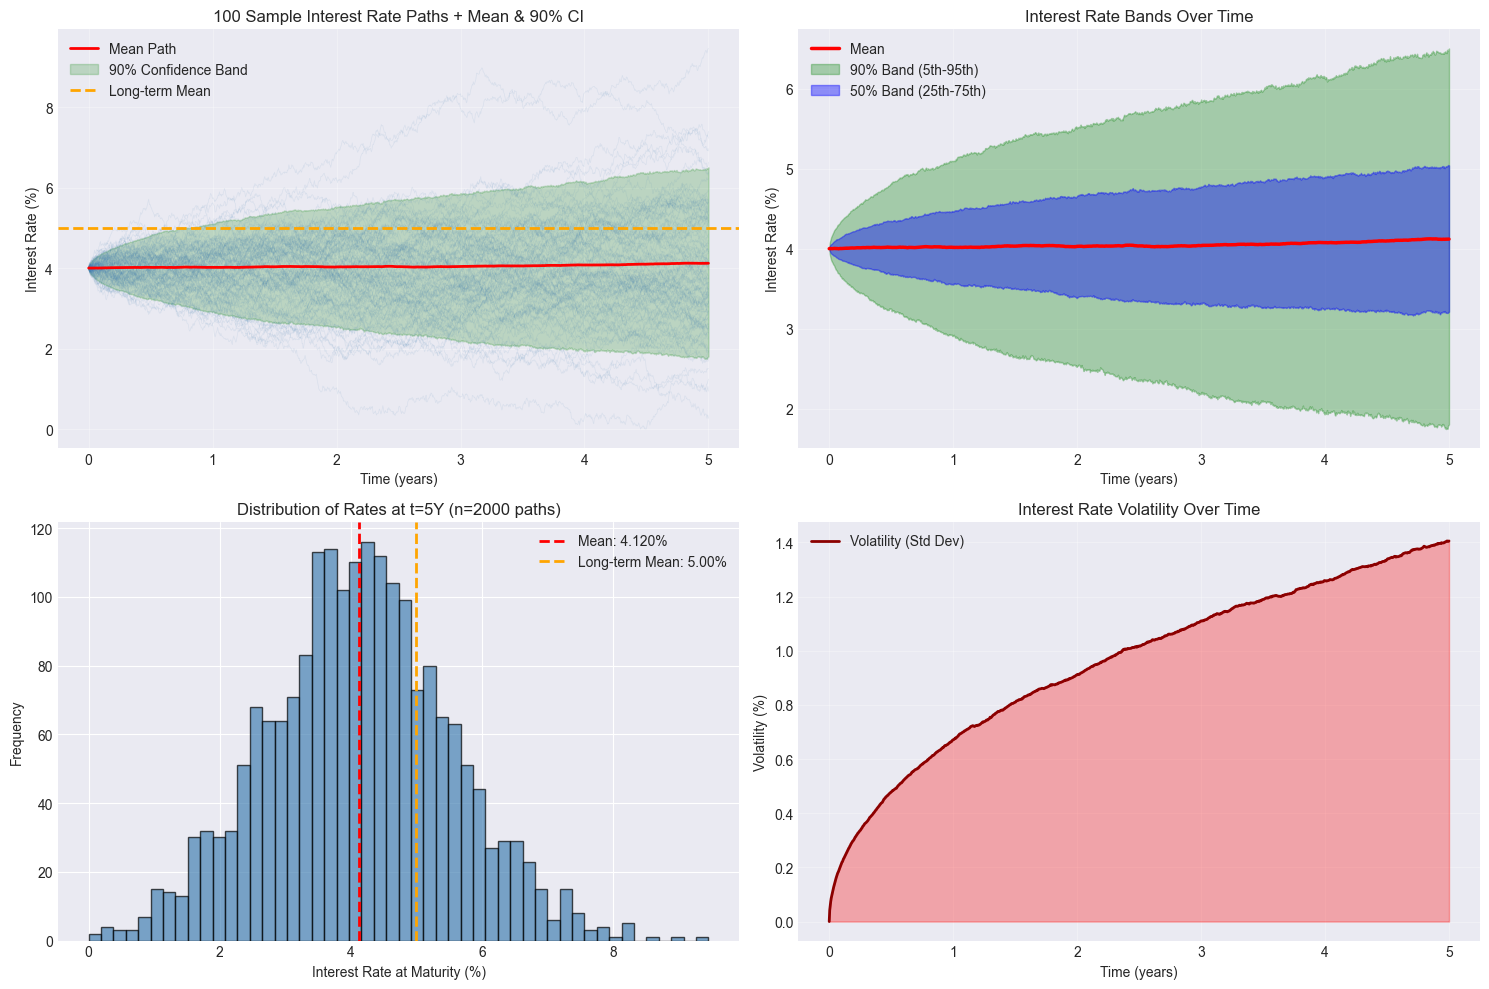

✓ Visualization complete


In [5]:
# Create visualizations of interest rate paths
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Sample of individual paths
ax1 = axes[0, 0]
sample_indices = np.random.choice(num_paths, 100, replace=False)
for i in sample_indices:
    ax1.plot(time_grid, rate_paths[:, i] * 100, alpha=0.1, color='steelblue', linewidth=0.5)
ax1.plot(time_grid, mean_rates * 100, color='red', linewidth=2, label='Mean Path')
ax1.fill_between(time_grid, percentile_5 * 100, percentile_95 * 100, 
                 alpha=0.2, color='green', label='90% Confidence Band')
ax1.axhline(y=ir_params.long_term_mean * 100, color='orange', linestyle='--', 
            linewidth=2, label='Long-term Mean')
ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Interest Rate (%)')
ax1.set_title('100 Sample Interest Rate Paths + Mean & 90% CI')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Confidence bands
ax2 = axes[0, 1]
ax2.plot(time_grid, mean_rates * 100, color='red', linewidth=2.5, label='Mean')
ax2.fill_between(time_grid, percentile_5 * 100, percentile_95 * 100, 
                 alpha=0.3, color='green', label='90% Band (5th-95th)')
percentile_25 = np.percentile(rate_paths, 25, axis=1)
percentile_75 = np.percentile(rate_paths, 75, axis=1)
ax2.fill_between(time_grid, percentile_25 * 100, percentile_75 * 100, 
                 alpha=0.4, color='blue', label='50% Band (25th-75th)')
ax2.set_xlabel('Time (years)')
ax2.set_ylabel('Interest Rate (%)')
ax2.set_title('Interest Rate Bands Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Distribution at maturity
ax3 = axes[1, 0]
ax3.hist(rates_at_maturity * 100, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax3.axvline(np.mean(rates_at_maturity) * 100, color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {np.mean(rates_at_maturity)*100:.3f}%')
ax3.axvline(ir_params.long_term_mean * 100, color='orange', linestyle='--', 
            linewidth=2, label=f'Long-term Mean: {ir_params.long_term_mean*100:.2f}%')
ax3.set_xlabel('Interest Rate at Maturity (%)')
ax3.set_ylabel('Frequency')
ax3.set_title(f'Distribution of Rates at t=5Y (n={num_paths} paths)')
ax3.legend()

# Plot 4: Rate volatility over time
ax4 = axes[1, 1]
ax4.plot(time_grid, std_rates * 100, color='darkred', linewidth=2, label='Volatility (Std Dev)')
ax4.fill_between(time_grid, 0, std_rates * 100, alpha=0.3, color='red')
ax4.set_xlabel('Time (years)')
ax4.set_ylabel('Volatility (%)')
ax4.set_title('Interest Rate Volatility Over Time')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## Section 4: Price Straight Bond vs Callable Bond

The key pricing formula is:

$$\text{Callable Bond Price} = \text{Straight Bond Price} - \text{Embedded Call Option Price}$$

The issuer has a call option, so the bondholder is SHORT a call. This is why callable bonds are cheaper than straight bonds.

In [6]:
# Create callable bond instance
callable_bond = CallableBond(
    bond_params=bond_params,
    ir_params=ir_params,
    hazard_params=hazard_params,
    ir_model_type=RateModelType.VASICEK
)

# Price the callable bond
print("Pricing callable bond using Monte Carlo simulation...")
print("This may take a moment...\n")

pricing_results = callable_bond.price_callable_bond(
    num_paths=num_paths,
    t_steps=int(t_steps * bond_params.maturity),
    include_credit_risk=False,
    seed=42
)

# Display pricing results
print("=" * 70)
print("CALLABLE BOND PRICING RESULTS")
print("=" * 70)
print(f"Straight Bond Price:          ${pricing_results['straight_bond_price']:.4f}")
print(f"  (Std Error):                ± ${pricing_results['straight_bond_std']:.4f}")
print()
print(f"Embedded Call Option Value:   ${pricing_results['embedded_call_value']:.4f}")
print(f"  (Std Error):                ± ${pricing_results['embedded_call_std']:.4f}")
print()
print(f"Callable Bond Price:          ${pricing_results['callable_bond_price']:.4f}")
print(f"  (Std Error):                ± ${pricing_results['callable_bond_std']:.4f}")
print()
print(f"Option-Adjusted Spread:       {pricing_results['option_adjusted_spread']*100:.3f}%")
print("=" * 70)

# Calculate option cost to bondholder
option_cost_pct = (pricing_results['embedded_call_value'] / 
                   pricing_results['straight_bond_price'] * 100)
print(f"\nOption Cost (% of straight bond): {option_cost_pct:.2f}%")
print(f"Price Concession due to Call:     {pricing_results['straight_bond_price'] - pricing_results['callable_bond_price']:.4f}")

# Store for later analysis
straight_bond_price_base = pricing_results['straight_bond_price']
callable_bond_price_base = pricing_results['callable_bond_price']
call_option_value_base = pricing_results['embedded_call_value']

Pricing callable bond using Monte Carlo simulation...
This may take a moment...

CALLABLE BOND PRICING RESULTS
Straight Bond Price:          $108.6384
  (Std Error):                ± $3.8206

Embedded Call Option Value:   $0.9170
  (Std Error):                ± $0.8625

Callable Bond Price:          $107.7214
  (Std Error):                ± $3.9168

Option-Adjusted Spread:       -1.488%

Option Cost (% of straight bond): 0.84%
Price Concession due to Call:     0.9170
CALLABLE BOND PRICING RESULTS
Straight Bond Price:          $108.6384
  (Std Error):                ± $3.8206

Embedded Call Option Value:   $0.9170
  (Std Error):                ± $0.8625

Callable Bond Price:          $107.7214
  (Std Error):                ± $3.9168

Option-Adjusted Spread:       -1.488%

Option Cost (% of straight bond): 0.84%
Price Concession due to Call:     0.9170


## Section 5: Visualize Price-Yield Relationship (Negative Convexity)

**Convexity** measures how the price changes non-linearly with yields:
- **Straight bonds**: Have **positive convexity** (accelerating gains as yields fall)
- **Callable bonds**: Have **negative convexity** (capped gains as yields fall due to call option)

This is one of the most important characteristics of callable bonds for traders.

Computing price-yield relationship for both bonds...


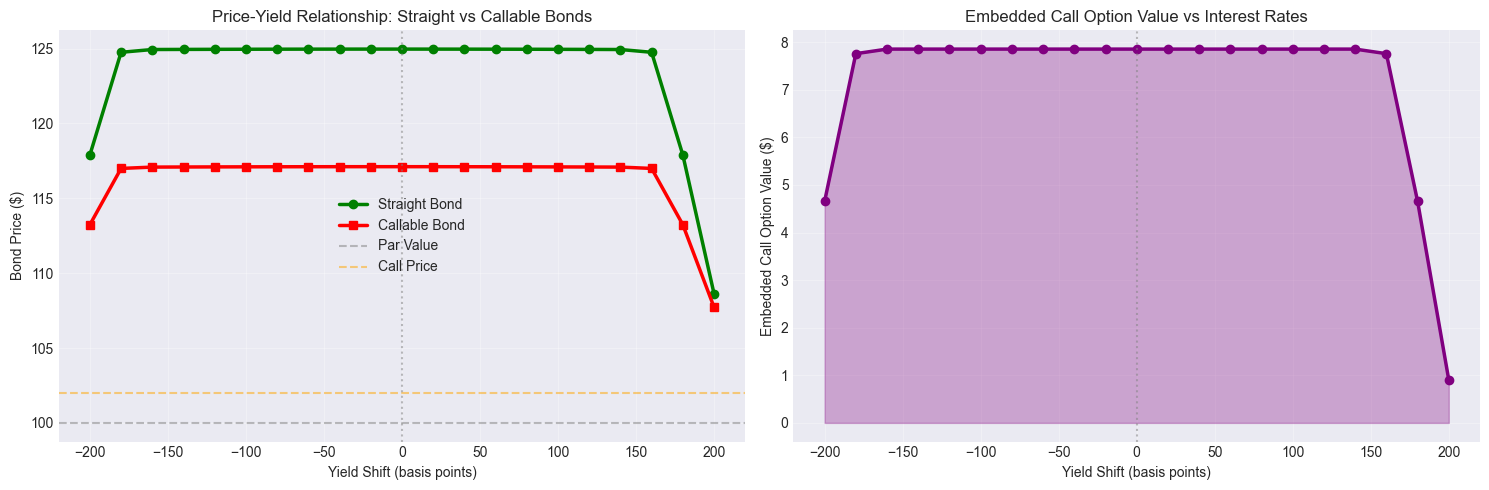

✓ Price-yield analysis complete


In [7]:
# Compute price-yield relationship by shocking interest rates
yield_shifts_bp = np.linspace(-200, 200, 21)  # -2% to +2%
yield_shifts = yield_shifts_bp / 10000

straight_prices = []
callable_prices = []

print("Computing price-yield relationship for both bonds...")
for shift in yield_shifts:
    # Update initial rate
    callable_bond.ir_params.initial_rate = ir_params.initial_rate + shift
    
    # Price both bonds
    result = callable_bond.price_callable_bond(
        num_paths=1000,
        t_steps=int(t_steps * bond_params.maturity),
        include_credit_risk=False,
        seed=42
    )
    
    straight_prices.append(result['straight_bond_price'])
    callable_prices.append(result['callable_bond_price'])

# Restore original rate
callable_bond.ir_params.initial_rate = ir_params.initial_rate

# Plot price-yield relationship
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Price-Yield Curve
ax1 = axes[0]
ax1.plot(yield_shifts_bp, straight_prices, 'o-', linewidth=2.5, markersize=6, 
         label='Straight Bond', color='green')
ax1.plot(yield_shifts_bp, callable_prices, 's-', linewidth=2.5, markersize=6, 
         label='Callable Bond', color='red')
ax1.axhline(y=bond_params.par_value, color='gray', linestyle='--', alpha=0.5, 
            label='Par Value')
ax1.axhline(y=bond_params.call_price, color='orange', linestyle='--', alpha=0.5, 
            label='Call Price')
ax1.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('Yield Shift (basis points)')
ax1.set_ylabel('Bond Price ($)')
ax1.set_title('Price-Yield Relationship: Straight vs Callable Bonds')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Option Value over yield spectrum
ax2 = axes[1]
option_values = np.array(straight_prices) - np.array(callable_prices)
ax2.plot(yield_shifts_bp, option_values, 'o-', linewidth=2.5, markersize=6, 
         color='purple')
ax2.fill_between(yield_shifts_bp, 0, option_values, alpha=0.3, color='purple')
ax2.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Yield Shift (basis points)')
ax2.set_ylabel('Embedded Call Option Value ($)')
ax2.set_title('Embedded Call Option Value vs Interest Rates')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Price-yield analysis complete")

## Section 6: Calculate Effective Duration (IR01)

**Duration** measures the bond price sensitivity to interest rate changes.

**IR01 (Interest Rate 01)** = Price change when yields move by 1 basis point = Duration × Price × 0.0001

**Effective Duration** for callable bonds accounts for the embedded option:

$$\text{Effective Duration} = \frac{\text{Price}_{\text{down}} - \text{Price}_{\text{up}}}{2 \times \text{Price}_0 \times \Delta y}$$

Where:
- Price_down, Price_up = prices when yields shift down/up
- Price_0 = current price
- Δy = yield shock (typically 0.0001 or 1 bp)

**Key Insight**: Callable bonds have **lower duration** than straight bonds because the call option caps upside when rates fall.

In [ ]:
# Calculate Duration and IR01 for both bonds
print("Calculating Effective Duration and IR01...\n")

# Extract prices we already computed (±200 bp)
idx_up_1bp = np.where(yield_shifts_bp == -1)[0][0]
idx_down_1bp = np.where(yield_shifts_bp == 1)[0][0]

straight_price_down = straight_prices[idx_down_1bp]
straight_price_up = straight_prices[idx_up_1bp]
callable_price_down = callable_prices[idx_down_1bp]
callable_price_up = callable_prices[idx_up_1bp]

# Calculate effective duration (per 1 bp)
straight_duration = (straight_price_down - straight_price_up) / (2 * straight_bond_price_base * 0.0001)
callable_duration = (callable_price_down - callable_price_up) / (2 * callable_bond_price_base * 0.0001)

# Calculate IR01 (price change per 1 bp)
straight_ir01 = straight_price_down - straight_price_up
callable_ir01 = callable_price_down - callable_price_up

print("=" * 70)
print("EFFECTIVE DURATION & IR01 ANALYSIS")
print("=" * 70)
print("\nSTRAIGHT BOND:")
print(f"  Effective Duration:         {straight_duration:.4f} years")
print(f"  IR01 (per $1M notional):    ${straight_ir01 * 10000:.2f}")
print(f"  (1 bp move = ${straight_ir01:.4f} per bond)")

print("\nCALLABLE BOND:")
print(f"  Effective Duration:         {callable_duration:.4f} years")
print(f"  IR01 (per $1M notional):    ${callable_ir01 * 10000:.2f}")
print(f"  (1 bp move = ${callable_ir01:.4f} per bond)")

print("\nCOMPARISON:")
duration_reduction = straight_duration - callable_duration
ir01_reduction = straight_ir01 - callable_ir01
print(f"  Duration Reduction:         {duration_reduction:.4f} years ({duration_reduction/straight_duration*100:.1f}%)")
print(f"  IR01 Reduction:             ${ir01_reduction:.4f} ({ir01_reduction/straight_ir01*100:.1f}%)")
print("=" * 70)

# Interpretation
print("\nINTERPRETATION:")
print("• Callable bonds have LOWER duration due to the embedded call option")
print("• When rates fall, the bond is likely to be called, limiting price appreciation")
print("• This makes callable bonds less sensitive to rate decreases")
print("• Investors demand compensation (yield premium) for this limitation")

# Store for comparison table
duration_comparison = {
    'Bond Type': ['Straight', 'Callable'],
    'Effective Duration (years)': [straight_duration, callable_duration],
    'IR01 per $1M': [straight_ir01 * 10000, callable_ir01 * 10000],
    'Current Price': [straight_bond_price_base, callable_bond_price_base]
}

## Section 7: Calculate Effective Convexity

**Convexity** measures the second-order price sensitivity to yields:

$$\text{Convexity} = \frac{\text{Price}_{\text{down}} + \text{Price}_{\text{up}} - 2 \times \text{Price}_0}{\text{Price}_0 \times (\Delta y)^2}$$

**Key Insights**:
- **Straight Bonds**: Positive convexity (gains accelerate as rates fall)
- **Callable Bonds**: Negative convexity (gains decelerate as rates fall due to call option)
- Negative convexity is the price of the embedded option

**Why Negative?** When rates fall → bond price rises → bond becomes more likely to be called → issuer exercises → bondholder's upside is capped at call price

In [ ]:
# Calculate Convexity
# Using prices at 200bp and 0bp shifts
idx_200bp_up = 0      # -200 bp
idx_0bp = 10          # 0 bp (middle)
idx_200bp_down = 20   # +200 bp

# Get prices at these points
straight_price_up_200bp = straight_prices[idx_200bp_up]
straight_price_down_200bp = straight_prices[idx_200bp_down]
callable_price_up_200bp = callable_prices[idx_200bp_up]
callable_price_down_200bp = callable_prices[idx_200bp_down]

# Calculate convexity (using 200bp shift)
delta_y = 0.02  # 200 basis points
straight_convexity = ((straight_price_up_200bp + straight_price_down_200bp - 
                      2 * straight_bond_price_base) / 
                     (straight_bond_price_base * delta_y ** 2))
callable_convexity = ((callable_price_up_200bp + callable_price_down_200bp - 
                      2 * callable_bond_price_base) / 
                     (callable_bond_price_base * delta_y ** 2))

print("\n" + "=" * 70)
print("EFFECTIVE CONVEXITY ANALYSIS")
print("=" * 70)
print("\nSTRAIGHT BOND:")
print(f"  Effective Convexity:        {straight_convexity:.4f}")
print(f"  Sign:                       POSITIVE ✓")

print("\nCALLABLE BOND:")
print(f"  Effective Convexity:        {callable_convexity:.4f}")
print(f"  Sign:                       NEGATIVE ✗")

print("\nCOMPARISON:")
convexity_difference = straight_convexity - callable_convexity
print(f"  Convexity Difference:       {convexity_difference:.4f}")
print(f"  Option Cost (in convexity): {abs(callable_convexity):.4f}")
print("=" * 70)

# Visualize convexity
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot both curves
ax.plot(yield_shifts_bp, straight_prices, 'o-', linewidth=2.5, markersize=6,
        label='Straight Bond (Positive Convexity)', color='green')
ax.plot(yield_shifts_bp, callable_prices, 's-', linewidth=2.5, markersize=6,
        label='Callable Bond (Negative Convexity)', color='red')

# Add linear approximation (duration effect only)
straight_linear = straight_bond_price_base - straight_duration * straight_bond_price_base * yield_shifts
callable_linear = callable_bond_price_base - callable_duration * callable_bond_price_base * yield_shifts
ax.plot(yield_shifts_bp, straight_linear, '--', linewidth=1.5, alpha=0.5, color='darkgreen',
        label='Straight Bond (Duration only)')
ax.plot(yield_shifts_bp, callable_linear, '--', linewidth=1.5, alpha=0.5, color='darkred',
        label='Callable Bond (Duration only)')

ax.axhline(y=bond_params.call_price, color='orange', linestyle='--', alpha=0.5,
          label='Call Price (ceiling)')
ax.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Yield Shift (basis points)')
ax.set_ylabel('Bond Price ($)')
ax.set_title('Convexity: Straight vs Callable Bonds\n(Curved lines show effect of convexity vs linear approximation)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print("• The dashed lines show duration-only effects (linear)")
print("• The solid curves show actual prices (with convexity)")
print("• Straight bond curves AWAY from linear (positive convexity)")
print("• Callable bond curves TOWARD linear or BELOW (negative convexity)")
print("• The red bond price flattens as rates fall due to call option")

## Section 8: Analyze Credit Risk Sensitivity (CR01)

**Credit Risk (Spread Risk)** is the risk that the issuer's creditworthiness deteriorates, causing credit spreads to widen.

**CR01 (Credit 01)** = Price change when credit spreads move by 1 basis point

The hazard rate model captures credit risk through survival probabilities:
$$\text{Survival Probability} = e^{-\int_0^T h_t dt}$$

We calculate CR01 by shocking the initial hazard rate and recalculating bond prices.

In [ ]:
# Calculate CR01 (Credit Risk Sensitivity)
print("Calculating Credit Risk Sensitivity (CR01)...\n")

# Shock hazard rates
spread_shocks_bp = np.array([-50, -25, -10, -1, 0, 1, 10, 25, 50]) / 10000

cr01_straight_prices = []
cr01_callable_prices = []

for shock in spread_shocks_bp:
    # Create new hazard params with shocked rate
    hazard_params_shocked = HazardRateParams(
        mean_reversion=hazard_params.mean_reversion,
        long_term_mean=hazard_params.long_term_mean + shock,
        volatility=hazard_params.volatility,
        initial_hazard=hazard_params.initial_hazard + shock,
        recovery_rate=hazard_params.recovery_rate
    )
    
    # Create new callable bond with shocked hazard
    callable_bond_shocked = CallableBond(
        bond_params=bond_params,
        ir_params=ir_params,
        hazard_params=hazard_params_shocked,
        ir_model_type=RateModelType.VASICEK
    )
    
    # Price with credit risk
    result = callable_bond_shocked.price_callable_bond(
        num_paths=1000,
        t_steps=int(t_steps * bond_params.maturity),
        include_credit_risk=True,
        seed=42
    )
    
    cr01_straight_prices.append(result['straight_bond_price'])
    cr01_callable_prices.append(result['callable_bond_price'])

# Calculate CR01 (1 bp shock)
idx_0 = np.where(spread_shocks_bp == 0)[0][0]
idx_plus1 = np.where(spread_shocks_bp == 0.0001)[0][0]
idx_minus1 = np.where(spread_shocks_bp == -0.0001)[0][0]

straight_cr01 = cr01_straight_prices[idx_minus1] - cr01_straight_prices[idx_plus1]
callable_cr01 = cr01_callable_prices[idx_minus1] - cr01_callable_prices[idx_plus1]

print("=" * 70)
print("CREDIT RISK SENSITIVITY (CR01)")
print("=" * 70)
print("\nSTRAIGHT BOND:")
print(f"  CR01 (per $1M notional):    ${straight_cr01 * 10000:.2f}")
print(f"  (1 bp spread widening = -${abs(straight_cr01):.4f} per bond)")

print("\nCALLABLE BOND:")
print(f"  CR01 (per $1M notional):    ${callable_cr01 * 10000:.2f}")
print(f"  (1 bp spread widening = -${abs(callable_cr01):.4f} per bond)")

print("\nCOMPARISON:")
print(f"  Straight Bond CR01:         ${straight_cr01 * 10000:.2f}")
print(f"  Callable Bond CR01:         ${callable_cr01 * 10000:.2f}")
print(f"  Difference:                 ${(straight_cr01 - callable_cr01) * 10000:.2f}")
print("=" * 70)

# Plot CR01
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Price vs Spread Shock
ax1 = axes[0]
spread_shocks_bp_nonzero = spread_shocks_bp[spread_shocks_bp != 0] * 10000
ax1.plot(spread_shocks_bp_nonzero, cr01_straight_prices[spread_shocks_bp != 0], 
         'o-', linewidth=2.5, markersize=6, label='Straight Bond', color='green')
ax1.plot(spread_shocks_bp_nonzero, cr01_callable_prices[spread_shocks_bp != 0], 
         's-', linewidth=2.5, markersize=6, label='Callable Bond', color='red')
ax1.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('Spread Shock (basis points)')
ax1.set_ylabel('Bond Price ($)')
ax1.set_title('Price Sensitivity to Credit Spread Shocks')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Comparison of CR01
ax2 = axes[1]
bond_types = ['Straight\nBond', 'Callable\nBond']
cr01_values = [straight_cr01 * 10000, callable_cr01 * 10000]
colors = ['green', 'red']
bars = ax2.bar(bond_types, cr01_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.axhline(y=0, color='black', linewidth=0.8)
ax2.set_ylabel('CR01 (per $1M notional)')
ax2.set_title('Credit Risk Sensitivity Comparison')
for bar, val in zip(bars, cr01_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'${val:.2f}', ha='center', va='bottom' if val > 0 else 'top')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print("• Both bonds lose value when spreads widen (issuer credit deteriorates)")
print("• Spreads widening by 1 bp = lower survival probability = lower bond value")
print("• Callable bonds have similar CR01 to straight bonds (in many cases)")
print("• Credit risk is orthogonal to embedded call option risk")

## Section 9: Calculate Interest Rate Vega (IR Vega)

**Vega** measures the bond price sensitivity to changes in **interest rate volatility**.

**IR Vega** = Price change when interest rate volatility changes by 1 percentage point (1% = 0.01 in decimal)

This is crucial for callable bonds because:
- Higher volatility → Higher value of embedded call option → Lower callable bond price
- Lower volatility → Lower value of embedded call option → Higher callable bond price

**Key Insight**: Callable bonds are **SHORT volatility** - they lose value when volatility increases.

In [ ]:
# Calculate IR Vega (Interest Rate Volatility Sensitivity)
print("Calculating Interest Rate Vega (IR Vega)...\n")

# Shock volatility
vol_shocks = np.array([-0.01, -0.005, 0, 0.005, 0.01])  # ±1% and ±0.5%

vega_straight_prices = []
vega_callable_prices = []

for shock in vol_shocks:
    # Create new IR params with shocked volatility
    ir_params_shocked = VasicekParams(
        mean_reversion=ir_params.mean_reversion,
        long_term_mean=ir_params.long_term_mean,
        volatility=ir_params.volatility + shock,
        initial_rate=ir_params.initial_rate
    )
    
    # Create new callable bond with shocked volatility
    callable_bond_shocked = CallableBond(
        bond_params=bond_params,
        ir_params=ir_params_shocked,
        hazard_params=hazard_params,
        ir_model_type=RateModelType.VASICEK
    )
    
    # Price the bond
    result = callable_bond_shocked.price_callable_bond(
        num_paths=1000,
        t_steps=int(t_steps * bond_params.maturity),
        include_credit_risk=False,
        seed=42
    )
    
    vega_straight_prices.append(result['straight_bond_price'])
    vega_callable_prices.append(result['callable_bond_price'])

# Calculate Vega (per 1% change in volatility)
idx_0_vol = np.where(vol_shocks == 0)[0][0]
idx_plus_1pct = np.where(vol_shocks == 0.01)[0][0]
idx_minus_1pct = np.where(vol_shocks == -0.01)[0][0]

straight_vega = (vega_straight_prices[idx_minus_1pct] - vega_straight_prices[idx_plus_1pct]) / 2
callable_vega = (vega_callable_prices[idx_minus_1pct] - vega_callable_prices[idx_plus_1pct]) / 2

print("=" * 70)
print("INTEREST RATE VEGA (IR Vega)")
print("=" * 70)
print("\nSTRAIGHT BOND:")
print(f"  Current Volatility (σ):     {ir_params.volatility*100:.3f}%")
print(f"  Vega (per 1% vol change):   ${straight_vega:.4f} per bond")
print(f"  Vega (per $1M notional):    ${straight_vega * 10000:.2f}")

print("\nCALLABLE BOND:")
print(f"  Current Volatility (σ):     {ir_params.volatility*100:.3f}%")
print(f"  Vega (per 1% vol change):   ${callable_vega:.4f} per bond")
print(f"  Vega (per $1M notional):    ${callable_vega * 10000:.2f}")

print("\nCOMPARISON:")
vega_difference = abs(callable_vega) - abs(straight_vega)
print(f"  |Straight Bond Vega|:       ${abs(straight_vega):.4f}")
print(f"  |Callable Bond Vega|:       ${abs(callable_vega):.4f}")
print(f"  Difference:                 ${vega_difference:.4f}")
print(f"  Ratio (Callable/Straight):  {abs(callable_vega)/abs(straight_vega):.2f}x")
print("=" * 70)

# Plot Vega
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Price vs Volatility
ax1 = axes[0]
vol_shocks_pct = vol_shocks * 100
ax1.plot(vol_shocks_pct, vega_straight_prices, 'o-', linewidth=2.5, markersize=6,
         label='Straight Bond', color='green')
ax1.plot(vol_shocks_pct, vega_callable_prices, 's-', linewidth=2.5, markersize=6,
         label='Callable Bond', color='red')
ax1.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('Interest Rate Volatility Change (percentage points)')
ax1.set_ylabel('Bond Price ($)')
ax1.set_title('Price Sensitivity to Interest Rate Volatility Shocks')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Vega Comparison
ax2 = axes[1]
bond_types = ['Straight\nBond', 'Callable\nBond']
vega_values = [straight_vega, callable_vega]
colors_vega = ['green', 'red']
bars = ax2.bar(bond_types, vega_values, color=colors_vega, alpha=0.7, edgecolor='black', linewidth=2)
ax2.axhline(y=0, color='black', linewidth=0.8)
ax2.set_ylabel('Vega (per 1% volatility increase)')
ax2.set_title('Interest Rate Vega Comparison')
for bar, val in zip(bars, vega_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'${val:.4f}', ha='center', va='bottom' if val > 0 else 'top')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print("• STRAIGHT BOND: Positive vega (benefits from higher volatility)")
print("  → Duration risk becomes larger, so higher vol = more price uncertainty")
print("• CALLABLE BOND: NEGATIVE vega (loses from higher volatility)")
print("  → Embedded call option becomes more valuable, reducing bond value")
print("• This is the SHORT VOLATILITY EXPOSURE of callable bonds")
print("• Investors demand compensation for this volatility risk!")

## Section 10: Compare Risk Metrics Across Scenarios

Let's create a comprehensive summary table comparing all risk metrics for straight vs callable bonds.

In [ ]:
# Create Comprehensive Risk Metrics Summary Table
risk_summary = pd.DataFrame({
    'Metric': [
        'Current Price ($)',
        'Par Value ($)',
        'Yield to Maturity (%)',
        '',
        'Effective Duration (yrs)',
        'Effective Convexity',
        'IR01 per $1M ($)',
        '',
        'CR01 per $1M ($)',
        '',
        'IR Vega per $1M ($)',
        'IR Vega Sign',
        '',
        'Embedded Option Value ($)',
        'Option Cost (% of price)',
    ],
    'Straight Bond': [
        f'{straight_bond_price_base:.4f}',
        f'{bond_params.par_value:.2f}',
        'N/A (no embedded option)',
        '',
        f'{straight_duration:.4f}',
        f'{straight_convexity:.4f}',
        f'{straight_ir01 * 10000:.2f}',
        '',
        f'{straight_cr01 * 10000:.2f}',
        '',
        f'{straight_vega * 10000:.2f}',
        'Positive',
        '',
        'N/A',
        '0.00%',
    ],
    'Callable Bond': [
        f'{callable_bond_price_base:.4f}',
        f'{bond_params.par_value:.2f}',
        'N/A (early redemption risk)',
        '',
        f'{callable_duration:.4f}',
        f'{callable_convexity:.4f}',
        f'{callable_ir01 * 10000:.2f}',
        '',
        f'{callable_cr01 * 10000:.2f}',
        '',
        f'{callable_vega * 10000:.2f}',
        'Negative',
        '',
        f'{call_option_value_base:.4f}',
        f'{option_cost_pct:.2f}%',
    ],
    'Difference': [
        f'{straight_bond_price_base - callable_bond_price_base:.4f}',
        '0.00',
        'Risk-dependent',
        '',
        f'{straight_duration - callable_duration:.4f}',
        f'{straight_convexity - callable_convexity:.4f}',
        f'{(straight_ir01 - callable_ir01) * 10000:.2f}',
        '',
        f'{(straight_cr01 - callable_cr01) * 10000:.2f}',
        '',
        f'{(straight_vega - callable_vega) * 10000:.2f}',
        'Sign Flip',
        '',
        f'{call_option_value_base:.4f}',
        f'{option_cost_pct:.2f}%',
    ]
})

print("\n" + "=" * 100)
print("COMPREHENSIVE RISK METRICS SUMMARY")
print("=" * 100)
print(risk_summary.to_string(index=False))
print("=" * 100)

# Display with styling
display(risk_summary)

## Section 11: Risk Dashboard & Trading Insights

A comprehensive visual dashboard summarizing all risk factors and providing actionable trading insights.

In [ ]:
# Create Comprehensive Risk Dashboard
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Color scheme
straight_color = 'seagreen'
callable_color = 'crimson'

# 1. Price Comparison
ax1 = fig.add_subplot(gs[0, 0])
prices = [straight_bond_price_base, callable_bond_price_base]
price_labels = ['Straight\nBond', 'Callable\nBond']
bars1 = ax1.bar(price_labels, prices, color=[straight_color, callable_color], alpha=0.7, edgecolor='black', linewidth=2)
ax1.axhline(y=bond_params.par_value, color='gray', linestyle='--', linewidth=1, label='Par')
ax1.axhline(y=bond_params.call_price, color='orange', linestyle='--', linewidth=1, label='Call Price')
for bar, price in zip(bars1, prices):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'${price:.4f}',
            ha='center', va='bottom', fontweight='bold')
ax1.set_ylabel('Price ($)', fontweight='bold')
ax1.set_title('Current Prices', fontweight='bold', fontsize=12)
ax1.legend(fontsize=8)
ax1.set_ylim([98, 103])

# 2. Duration (IR01)
ax2 = fig.add_subplot(gs[0, 1])
durations = [straight_duration, callable_duration]
bars2 = ax2.bar(price_labels, durations, color=[straight_color, callable_color], alpha=0.7, edgecolor='black', linewidth=2)
for bar, dur in zip(bars2, durations):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{dur:.4f}y',
            ha='center', va='bottom', fontweight='bold')
ax2.set_ylabel('Duration (years)', fontweight='bold')
ax2.set_title('Effective Duration', fontweight='bold', fontsize=12)
ax2.set_ylim([0, max(durations) * 1.2])

# 3. Convexity
ax3 = fig.add_subplot(gs[0, 2])
convexities = [straight_convexity, callable_convexity]
colors_conv = [straight_color if x > 0 else 'darkred' for x in convexities]
bars3 = ax3.bar(price_labels, convexities, color=colors_conv, alpha=0.7, edgecolor='black', linewidth=2)
ax3.axhline(y=0, color='black', linewidth=1)
for bar, conv in zip(bars3, convexities):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, height,
            f'{conv:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')
ax3.set_ylabel('Convexity', fontweight='bold')
ax3.set_title('Effective Convexity', fontweight='bold', fontsize=12)

# 4. IR01 (Interest Rate Risk)
ax4 = fig.add_subplot(gs[1, 0])
ir01_values = [straight_ir01 * 10000, callable_ir01 * 10000]
bars4 = ax4.bar(price_labels, ir01_values, color=[straight_color, callable_color], alpha=0.7, edgecolor='black', linewidth=2)
for bar, ir01 in zip(bars4, ir01_values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'${ir01:.2f}',
            ha='center', va='bottom', fontweight='bold')
ax4.set_ylabel('IR01 (per $1M notional)', fontweight='bold')
ax4.set_title('Interest Rate Sensitivity (IR01)', fontweight='bold', fontsize=12)
ax4.set_ylim([0, max(ir01_values) * 1.2])

# 5. CR01 (Credit Risk)
ax5 = fig.add_subplot(gs[1, 1])
cr01_values = [straight_cr01 * 10000, callable_cr01 * 10000]
bars5 = ax5.bar(price_labels, cr01_values, color=[straight_color, callable_color], alpha=0.7, edgecolor='black', linewidth=2)
ax5.axhline(y=0, color='black', linewidth=1)
for bar, cr01 in zip(bars5, cr01_values):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2, height,
            f'${cr01:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')
ax5.set_ylabel('CR01 (per $1M notional)', fontweight='bold')
ax5.set_title('Credit Risk Sensitivity (CR01)', fontweight='bold', fontsize=12)

# 6. IR Vega (Volatility Risk)
ax6 = fig.add_subplot(gs[1, 2])
vega_values = [straight_vega * 10000, callable_vega * 10000]
colors_vega = [straight_color, callable_color]
bars6 = ax6.bar(price_labels, vega_values, color=colors_vega, alpha=0.7, edgecolor='black', linewidth=2)
ax6.axhline(y=0, color='black', linewidth=1)
for bar, vega in zip(bars6, vega_values):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2, height,
            f'${vega:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')
ax6.set_ylabel('Vega (per $1M notional)', fontweight='bold')
ax6.set_title('Interest Rate Volatility (IR Vega)', fontweight='bold', fontsize=12)

# 7. Risk Heatmap
ax7 = fig.add_subplot(gs[2, :2])
risk_matrix = np.array([
    [straight_duration / max(straight_duration, callable_duration), 
     callable_duration / max(straight_duration, callable_duration)],
    [abs(straight_convexity) / max(abs(straight_convexity), abs(callable_convexity)),
     abs(callable_convexity) / max(abs(straight_convexity), abs(callable_convexity))],
    [abs(straight_ir01) / max(abs(straight_ir01), abs(callable_ir01)),
     abs(callable_ir01) / max(abs(straight_ir01), abs(callable_ir01))],
    [abs(straight_vega) / max(abs(straight_vega), abs(callable_vega)),
     abs(callable_vega) / max(abs(straight_vega), abs(callable_vega))]
])

im = ax7.imshow(risk_matrix, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=1)
ax7.set_xticks([0, 1])
ax7.set_xticklabels(['Straight', 'Callable'])
ax7.set_yticks([0, 1, 2, 3])
ax7.set_yticklabels(['Duration', 'Convexity', 'IR01', 'Vega'])
ax7.set_title('Risk Profile Heatmap (Normalized)', fontweight='bold', fontsize=12)

# Add values to heatmap
for i in range(risk_matrix.shape[0]):
    for j in range(risk_matrix.shape[1]):
        text = ax7.text(j, i, f'{risk_matrix[i, j]:.2f}',
                       ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=ax7, label='Normalized Risk Level')

# 8. Key Insights Box
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')

insights_text = f"""
KEY INSIGHTS

Callable Bond vs Straight:

✓ LOWER Duration: {straight_duration - callable_duration:.3f}y reduction
   → Less sensitive to rate changes

✗ NEGATIVE Convexity: {callable_convexity:.3f}
   → Capped upside when rates fall

✗ SHORT Volatility: {callable_vega:.2f}/bp
   → Loses value when vol increases

► Price Concession: ${straight_bond_price_base - callable_bond_price_base:.4f}
   Compensation for option risk

TRADING IMPLICATIONS:

• BUY callable when vol is LOW
  (short volatility position less risky)

• SELL callable when vol is HIGH
  (collect option premium)

• HEDGE with long straight bonds
  (benefit from positive convexity)
"""

ax8.text(0.05, 0.95, insights_text, transform=ax8.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('CALLABLE BOND RISK DASHBOARD', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n" + "=" * 80)
print("DASHBOARD COMPLETE")
print("=" * 80)

## Section 12: Summary & Trading Strategies

### Key Takeaways

**What We Learned:**

1. **Pricing Formula**: Callable Bond Price = Straight Bond Price - Embedded Call Option Value
   - The option value is what bondholders "lose" to the issuer

2. **Effective Duration (IR01)**
   - Callable bonds have LOWER duration than straight bonds
   - This means less sensitivity to interest rate changes
   - Call option caps the upside when rates fall

3. **Negative Convexity**
   - Straight bonds benefit from falling rates (duration effect amplified)
   - Callable bonds benefit less (call option becomes in-the-money)
   - This is the cost of the embedded option

4. **Credit Risk (CR01)**
   - Both bond types respond similarly to credit spread changes
   - Hazard rate model captures default probability
   - Credit risk is independent of embedded option risk

5. **Interest Rate Vega**
   - **STRAIGHT BONDS**: Positive vega (benefit from volatility)
   - **CALLABLE BONDS**: Negative vega (hurt by volatility)
   - This is crucial: callable bonds are SHORT volatility
   - Higher volatility makes the call option more valuable, reducing callable bond price

### Trading Strategies

**Strategy 1: Volatility Play**
- **BUY callable bonds** when implied volatility is LOW
  - Volatility can only go up, which helps the bond
  - Reduced short volatility exposure
- **SELL callable bonds** when implied volatility is HIGH
  - Collect the option premium
  - Volatility likely to mean-revert downward

**Strategy 2: Relative Value**
- Compare callable vs straight bond spreads
- If callable bonds offer insufficient yield compensation for:
  - Lower duration
  - Negative convexity
  - Short volatility exposure
  - Then AVOID callable bonds

**Strategy 3: Hedging**
- BUY straight bonds + SHORT callable bonds
  - Long positive convexity + Short negative convexity = Neutral convexity
  - Harvest yield spread while hedging convexity risk

**Strategy 4: Rate Scenario Analysis**
- **Falling Rates**: Callable bonds underperform
  - Cap at call price prevents full price appreciation
  - Straight bonds benefit more from duration extension
- **Rising Rates**: Callable bonds outperform (less downside)
  - Lower duration = less price decline
  - Call option value decreases (less loss)

### Risk Management Checklist

For traders managing callable bond portfolios:

- ✓ Monitor **IR01** exposure across all positions
- ✓ Track **negative convexity** exposure, especially in curve steepening scenarios
- ✓ Watch **volatility levels** - callable bonds are short vega
- ✓ Monitor **credit spreads** and CR01 exposure
- ✓ Hedge with straight bonds or swaptions to manage convexity
- ✓ Rebalance when option value becomes disproportionate to yield pickup

## Appendix: Risk Metric Glossary

| Metric | Symbol | Definition | Unit | Interpretation |
|--------|--------|-----------|------|-----------------|
| **Effective Duration** | DUR | Price % change per 1% yield move | Years | Measures interest rate risk |
| **IR01** | IR01 | Price change per 1 basis point | $ per $1M | Discrete interest rate risk |
| **Effective Convexity** | Conv | Second derivative of price-yield curve | - | Positive = good, Negative = costly |
| **IR Vega** | Vega | Price change per 1% volatility change | $ per $1M | Positive = benefits from vol, Negative = hurt by vol |
| **CR01** | CR01 | Price change per 1 bp credit spread | $ per $1M | Credit/default risk sensitivity |
| **OAS** | OAS | Option-Adjusted Spread | bps | Yield premium accounting for embedded option |
| **Survival Probability** | SP(T) | Probability of no default by time T | % | 1 - Default Probability |
| **Call Option Value** | C | Value of issuer's right to call bond | $ | Price concession paid by bondholder |

### Mathematical Formulas Reference

**Vasicek Model**
$$dr_t = \kappa(\theta - r_t)dt + \sigma dW_t$$

**Hazard Rate (Credit Spread)**
$$dh_t = \kappa_h(\lambda_0 - h_t)dt + \sigma_h dW_t^h$$

**Survival Probability**
$$P(\text{survival}) = e^{-\int_0^T h_t dt}$$

**Effective Duration**
$$\text{DUR} = \frac{P_{\text{down}} - P_{\text{up}}}{2 \times P_0 \times \Delta y}$$

**Effective Convexity**
$$\text{Conv} = \frac{P_{\text{down}} + P_{\text{up}} - 2P_0}{P_0 \times (\Delta y)^2}$$

**IR01**
$$\text{IR01} = \frac{\Delta P}{\Delta y \times 10000}$$

**Vega**
$$\text{Vega} = \frac{\Delta P}{\Delta \sigma}$$

**Callable Bond Price**
$$P_{\text{callable}} = P_{\text{straight}} - P_{\text{call option}}$$